# K-Nearest Neighbors: Visual Intuition & When It Fails

**Duration**: 20-25 minutes

Now that you're implementing KNN from scratch in HW2, let's build intuition about:
1. **How changing k affects decision boundaries**
2. **When and why KNN fails**
3. **What this means for real-world applications**

We'll use sklearn's implementation to focus on the concepts, not the code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

In [22]:
# Helper function to plot decision boundary
def plot_decision_boundary(X, y, k, ax, title):
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    # Create mesh for decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # Calculate step size for meshgrid - adjust based on data range
    hx = (x_max - x_min) / 100
    hy = (y_max - y_min) / 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))
    # Predict on mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = knn.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot
    ax.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors="black")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

## 1. The Effect of k: From Chaos to Simplicity

Let's see how k controls the **bias-variance tradeoff** in KNN.

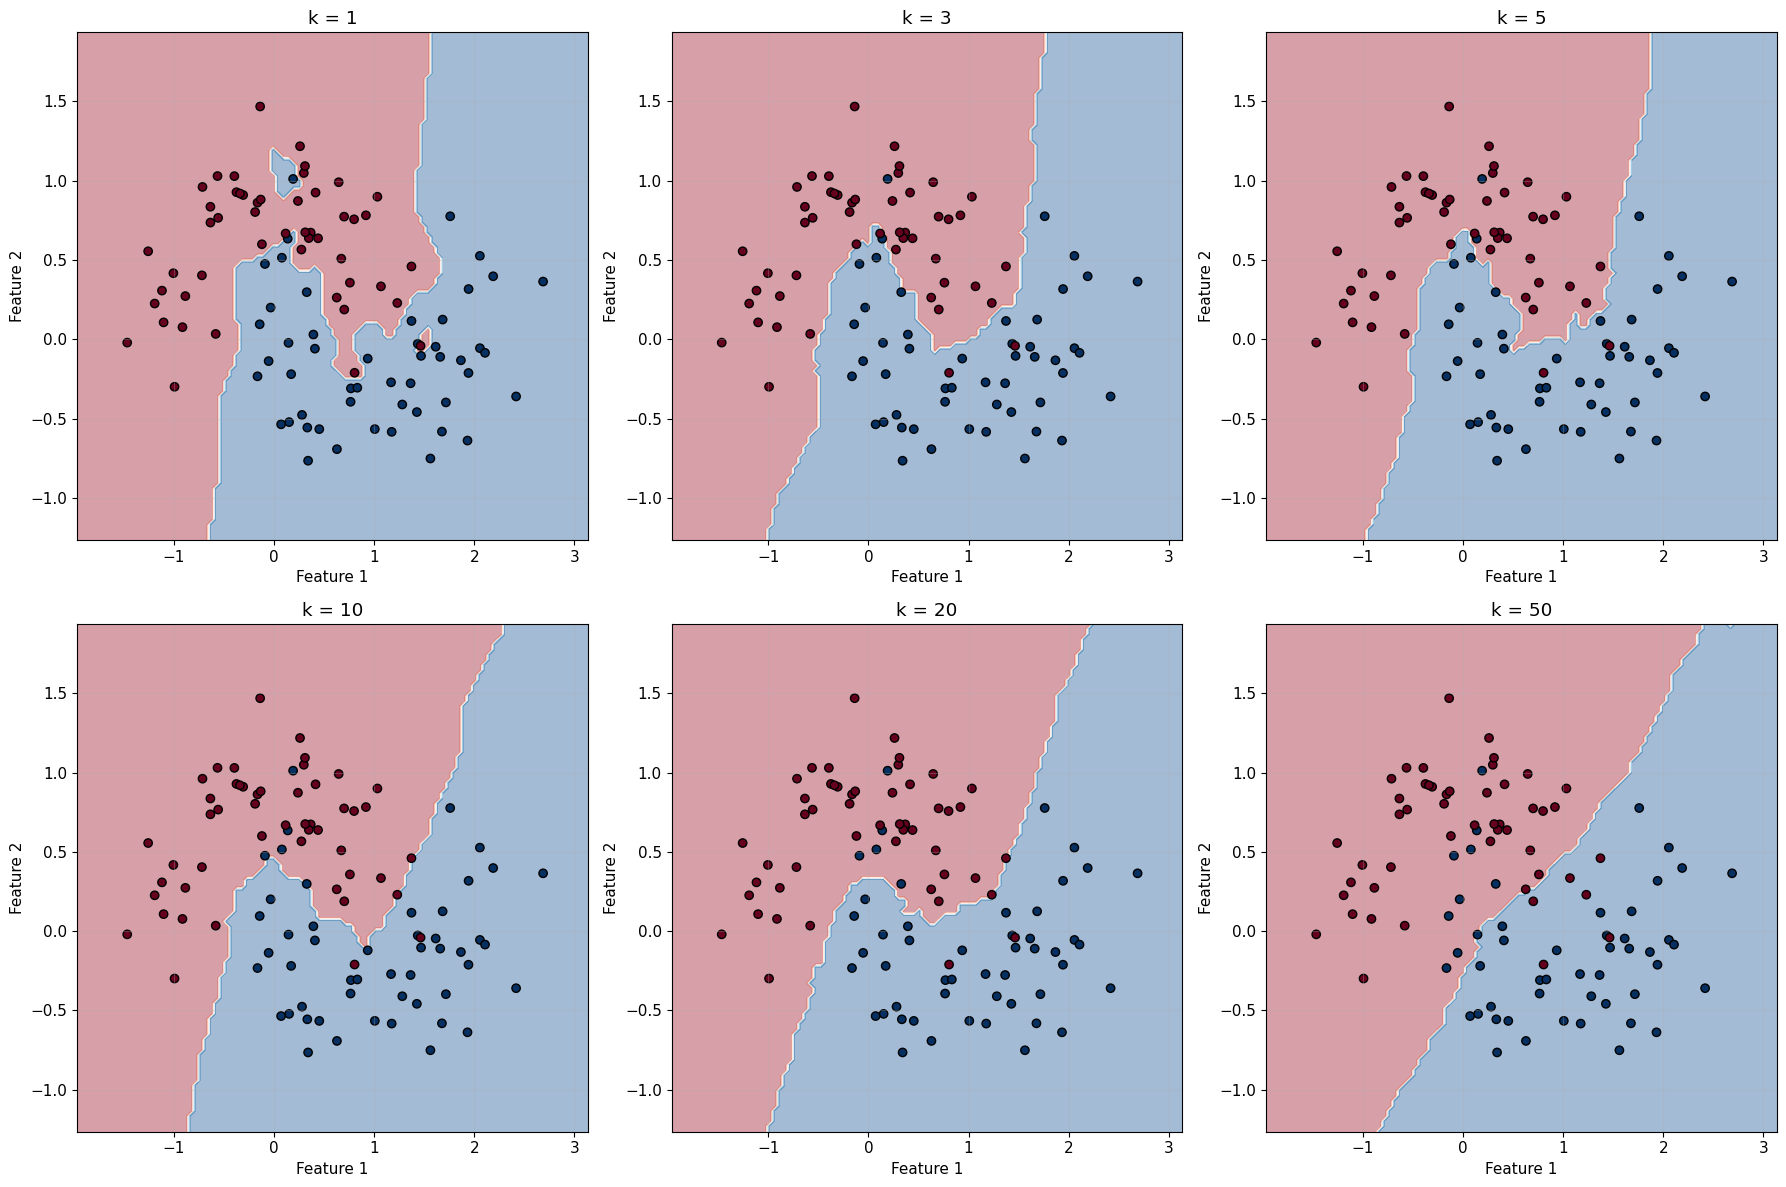

🎯 Key Observations:
• k=1: Very complex, jagged boundaries → HIGH VARIANCE, LOW BIAS
• k=50: Very simple, smooth boundaries → LOW VARIANCE, HIGH BIAS
• Sweet spot usually somewhere in the middle (k=3-10 here)

💡 This is the bias-variance tradeoff in action!


In [23]:
# Create a two moons dataset
X, y = make_moons(n_samples=100, noise=0.25, random_state=42)

# Plot different k values
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
k_values = [1, 3, 5, 10, 20, 50]

for i, k in enumerate(k_values):
    row, col = i // 3, i % 3
    plot_decision_boundary(X, y, k, axes[row, col], f"k = {k}")

plt.tight_layout()
plt.show()

print("🎯 Key Observations:")
print("• k=1: Very complex, jagged boundaries → HIGH VARIANCE, LOW BIAS")
print("• k=50: Very simple, smooth boundaries → LOW VARIANCE, HIGH BIAS")
print("• Sweet spot usually somewhere in the middle (k=3-10 here)")
print("\n💡 This is the bias-variance tradeoff in action!")

## 2. When KNN Fails: Problem Datasets

Let's look at datasets where KNN struggles and understand **why**.

### Failure Case 1: Different Feature Scales

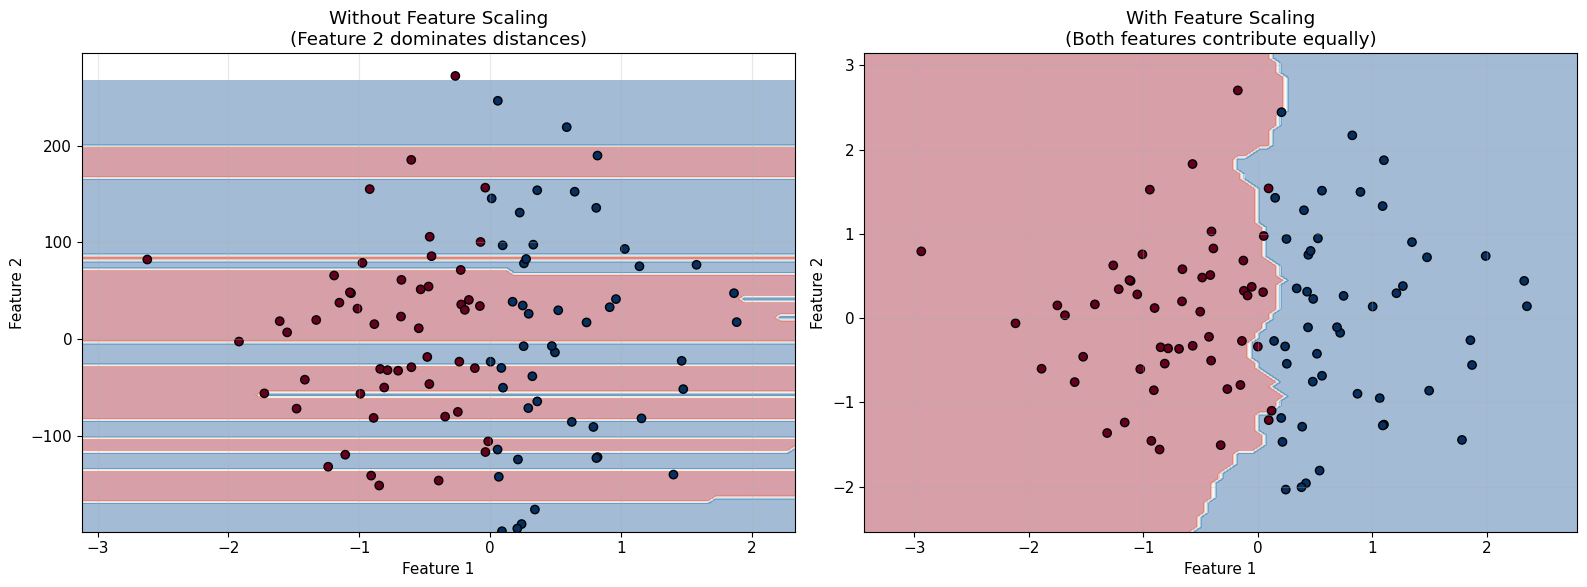

🚨 Problem: Feature 2 has 500x larger scale than Feature 1
   → Euclidean distance is dominated by Feature 2
   → KNN ignores the important Feature 1

✅ Solution: Scale/normalize features before using KNN


In [25]:
# Create dataset where features have very different scales
np.random.seed(42)
n_samples = 100

# Feature 1: small scale (0-2)
# Feature 2: large scale (0-1000)
X_scale = np.random.randn(n_samples, 2)
X_scale[:, 0] *= 1  # Feature 1: scale ~1
X_scale[:, 1] *= 100  # Feature 2: scale ~500

# True decision boundary depends on Feature 1 (the small-scale feature)
y_scale = (X_scale[:, 0] > 0).astype(int)

# Compare with and without scaling
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Without scaling
knn_unscaled = KNeighborsClassifier(n_neighbors=5)
plot_decision_boundary(
    X_scale,
    y_scale,
    5,
    axes[0],
    "Without Feature Scaling\n(Feature 2 dominates distances)",
)

# With scaling
scaler = StandardScaler()
X_scale_normalized = scaler.fit_transform(X_scale)
plot_decision_boundary(
    X_scale_normalized,
    y_scale,
    5,
    axes[1],
    "With Feature Scaling\n(Both features contribute equally)",
)

plt.tight_layout()
plt.show()

print("🚨 Problem: Feature 2 has 500x larger scale than Feature 1")
print("   → Euclidean distance is dominated by Feature 2")
print("   → KNN ignores the important Feature 1")
print("\n✅ Solution: Scale/normalize features before using KNN")

### Failure Case 2: Curse of Dimensionality

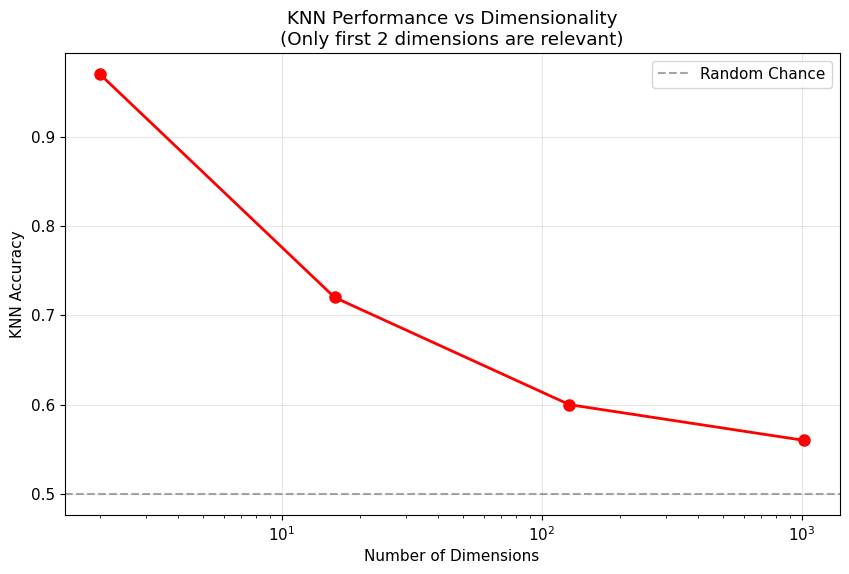

📉 Accuracy by dimension:
     2D: 0.970
    16D: 0.720
   128D: 0.600
   1024D: 0.560

🚨 Problem: In high dimensions, all points become roughly equidistant
   → 'Nearest' neighbors aren't really 'near'
   → Noise dimensions dominate the distance calculation

✅ Solutions: Feature selection, dimensionality reduction (PCA, t-SNE)


In [32]:
# Demonstrate curse of dimensionality
def test_knn_performance_vs_dimensions():
    dimensions = [2, 16, 128, 1024]
    accuracies = []

    for dim in dimensions:
        # Create high-dimensional dataset
        X_high_d = np.random.randn(300, dim)
        # Only first 2 dimensions matter for classification
        y_high_d = ((X_high_d[:, 0] + X_high_d[:, 1]) > 0).astype(int)

        # Train/test split
        n_train = 200
        X_train, X_test = X_high_d[:n_train], X_high_d[n_train:]
        y_train, y_test = y_high_d[:n_train], y_high_d[n_train:]

        # Test KNN
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        accuracy = knn.score(X_test, y_test)
        accuracies.append(accuracy)

    return dimensions, accuracies


dims, accs = test_knn_performance_vs_dimensions()

plt.figure(figsize=(10, 6))
plt.plot(dims, accs, "ro-", linewidth=2, markersize=8)
plt.xscale("log")
plt.axhline(y=0.5, color="gray", linestyle="--", alpha=0.7, label="Random Chance")
plt.xlabel("Number of Dimensions")
plt.ylabel("KNN Accuracy")
plt.title("KNN Performance vs Dimensionality\n(Only first 2 dimensions are relevant)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("📉 Accuracy by dimension:")
for dim, acc in zip(dims, accs):
    print(f"   {dim:3d}D: {acc:.3f}")

print("\n🚨 Problem: In high dimensions, all points become roughly equidistant")
print("   → 'Nearest' neighbors aren't really 'near'")
print("   → Noise dimensions dominate the distance calculation")
print("\n✅ Solutions: Feature selection, dimensionality reduction (PCA, t-SNE)")

### Failure Case 3: Imbalanced Classes

Class distribution: [270  30]
Class 0: 90.0%
Class 1: 10.0%


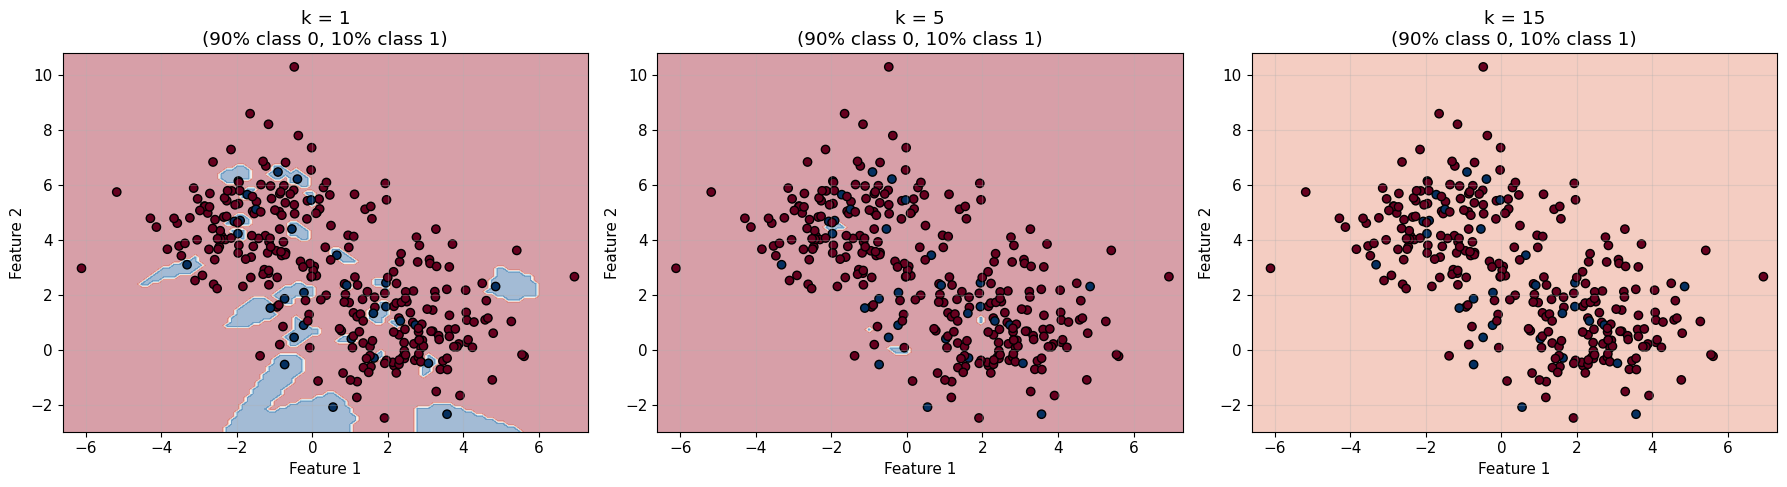


🚨 Problem: With imbalanced classes, larger k favors the majority class
   → k=15: minority class regions shrink or disappear entirely

✅ Solutions:
   • Use smaller k values
   • Balance the training data (resampling)
   • Use distance weighting (closer neighbors have more influence)


In [33]:
# Create severely imbalanced dataset
X_imb, y_imb = make_blobs(
    n_samples=300, centers=2, cluster_std=1.5, center_box=(-5.0, 5.0), random_state=42
)

# Make it severely imbalanced (90% class 0, 10% class 1)
n_majority = int(0.9 * len(X_imb))
y_imb_unbalanced = np.zeros(len(X_imb))
y_imb_unbalanced[n_majority:] = 1

# Shuffle to mix the classes
shuffle_idx = np.random.permutation(len(X_imb))
X_imb, y_imb_unbalanced = X_imb[shuffle_idx], y_imb_unbalanced[shuffle_idx]

print(f"Class distribution: {np.bincount(y_imb_unbalanced.astype(int))}")
print(f"Class 0: {np.mean(y_imb_unbalanced == 0)*100:.1f}%")
print(f"Class 1: {np.mean(y_imb_unbalanced == 1)*100:.1f}%")

# Test different k values on imbalanced data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
k_values_imb = [1, 5, 15]

for i, k in enumerate(k_values_imb):
    plot_decision_boundary(
        X_imb,
        y_imb_unbalanced.astype(int),
        k,
        axes[i],
        f"k = {k}\n(90% class 0, 10% class 1)",
    )

plt.tight_layout()
plt.show()

print("\n🚨 Problem: With imbalanced classes, larger k favors the majority class")
print("   → k=15: minority class regions shrink or disappear entirely")
print("\n✅ Solutions:")
print("   • Use smaller k values")
print("   • Balance the training data (resampling)")
print("   • Use distance weighting (closer neighbors have more influence)")

### Failure Case 4: Irrelevant Features

Dataset: 400 samples, 22 features (2 relevant, 8 noise)

KNN Accuracy:
With relevant features only:     0.970
With irrelevant features added:  0.630
Performance drop: 0.340


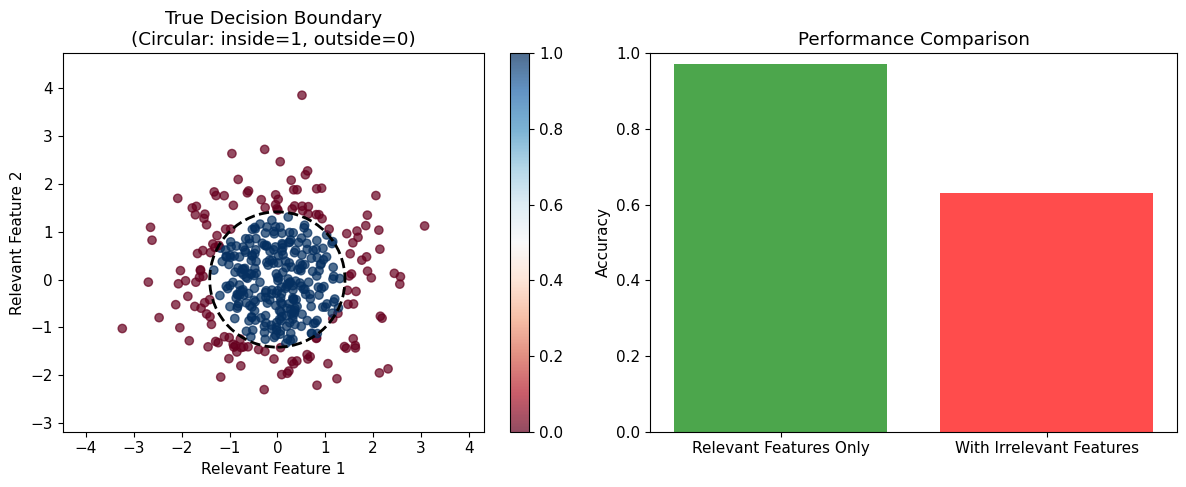


🚨 Problem: Irrelevant features add noise to distance calculations
   → Points that should be 'near' in relevant space appear 'far'
   → KNN finds wrong neighbors

✅ Solutions: Feature selection, domain knowledge, dimensionality reduction


In [36]:
# Create dataset with irrelevant features
np.random.seed(42)
n_samples = 400

# Only 2 relevant features
X_relevant = np.random.randn(n_samples, 2)
y_relevant = ((X_relevant[:, 0] ** 2 + X_relevant[:, 1] ** 2) < 2).astype(int)

# Add 8 irrelevant noisy features
X_noise = np.random.randn(n_samples, 20)
X_with_noise = np.hstack([X_relevant, X_noise])

print(
    f"Dataset: {n_samples} samples, {X_with_noise.shape[1]} features (2 relevant, 8 noise)"
)

# Compare performance
n_train = 300
X_train_rel, X_test_rel = X_relevant[:n_train], X_relevant[n_train:]
X_train_noise, X_test_noise = X_with_noise[:n_train], X_with_noise[n_train:]
y_train, y_test = y_relevant[:n_train], y_relevant[n_train:]

# Test with relevant features only
knn_relevant = KNeighborsClassifier(n_neighbors=5)
knn_relevant.fit(X_train_rel, y_train)
acc_relevant = knn_relevant.score(X_test_rel, y_test)

# Test with irrelevant features included
knn_noise = KNeighborsClassifier(n_neighbors=5)
knn_noise.fit(X_train_noise, y_train)
acc_noise = knn_noise.score(X_test_noise, y_test)

print(f"\nKNN Accuracy:")
print(f"With relevant features only:     {acc_relevant:.3f}")
print(f"With irrelevant features added:  {acc_noise:.3f}")
print(f"Performance drop: {acc_relevant - acc_noise:.3f}")

# Visualize the relevant features
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(
    X_relevant[:, 0], X_relevant[:, 1], c=y_relevant, cmap=plt.cm.RdBu, alpha=0.7
)
plt.xlabel("Relevant Feature 1")
plt.ylabel("Relevant Feature 2")
plt.title("True Decision Boundary\n(Circular: inside=1, outside=0)")
plt.colorbar(scatter)
circle = plt.Circle(
    (0, 0), np.sqrt(2), fill=False, color="black", linewidth=2, linestyle="--"
)
plt.gca().add_patch(circle)
plt.axis("equal")

plt.subplot(1, 2, 2)
plt.bar(
    ["Relevant Features Only", "With Irrelevant Features"],
    [acc_relevant, acc_noise],
    color=["green", "red"],
    alpha=0.7,
)
plt.ylabel("Accuracy")
plt.title("Performance Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n🚨 Problem: Irrelevant features add noise to distance calculations")
print("   → Points that should be 'near' in relevant space appear 'far'")
print("   → KNN finds wrong neighbors")
print("\n✅ Solutions: Feature selection, domain knowledge, dimensionality reduction")

## 3. Key Takeaways: When to Use (and Avoid) KNN

### ✅ KNN Works Well When:
- **Local patterns matter**: Decision boundaries are complex/non-linear
- **Features are properly scaled**: All features contribute meaningfully to distance
- **Low-to-moderate dimensions**: < 20 features, or after dimensionality reduction
- **Balanced classes**: No severe class imbalance
- **Relevant features**: Most/all features are informative
- **Sufficient data**: Enough samples to represent the local structure

### ❌ Avoid KNN When:
- **High dimensions** without feature selection (curse of dimensionality)
- **Different feature scales** without normalization
- **Severe class imbalance** (majority class dominates)
- **Many irrelevant features** (noise dominates signal)
- **Very large datasets** (computational cost)
- **Varying data density** across regions

### 🛠️ Practical Tips:
1. **Always normalize/scale features** before using KNN
2. **Use cross-validation** to choose k
3. **Try different distance metrics** (Euclidean, Manhattan, cosine)
4. **Consider feature selection** or dimensionality reduction
5. **Use odd k values** to avoid ties in binary classification
6. **Start with k = √n** as a rough guideline

### 💡 Remember:
KNN's core assumption is that **"nearby points should have similar labels."** When this assumption breaks down (due to irrelevant features, poor scaling, high dimensions, etc.), KNN fails.

The beauty of KNN is its simplicity - but this simplicity requires careful preprocessing and thoughtful application!